In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [7]:
# Load the dataset
file_path = 'E:/task for job/MMM_test_data.csv'
df = pd.read_csv(file_path)

In [8]:
# Adstock transformation function
def adstock_transform(x, alpha):
    result = [x[0]]
    for i in range(1, len(x)):
        adstock_value = x[i] + alpha * result[i-1]
        result.append(adstock_value)
    return result

# Apply adstock transformation
alpha = 0.820616877 # value derived from domain knwoledge  
for i in range(1, 8):
    channel = f'spend_channel_{i}'
    df[f'adstock_{channel}'] = adstock_transform(df[channel].values, alpha)

# Define Bayesian Mixed-Media Model
adstock_columns = [f'adstock_spend_channel_{i}' for i in range(1, 8)]
X = df[adstock_columns].values
y = df['revenue'].values

In [9]:
with pm.Model() as model:
    beta = pm.Normal('beta', mu=0, sigma=1, shape=7)
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    mu = intercept + pm.math.dot(X, beta)
    sigma = pm.HalfNormal('sigma', sigma=1)
    revenue = pm.Normal('revenue', mu=mu, sigma=sigma, observed=y)
    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept, sigma]


e:\task for job\env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25256 seconds.


Sampling: [revenue]


e:\task for job\env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

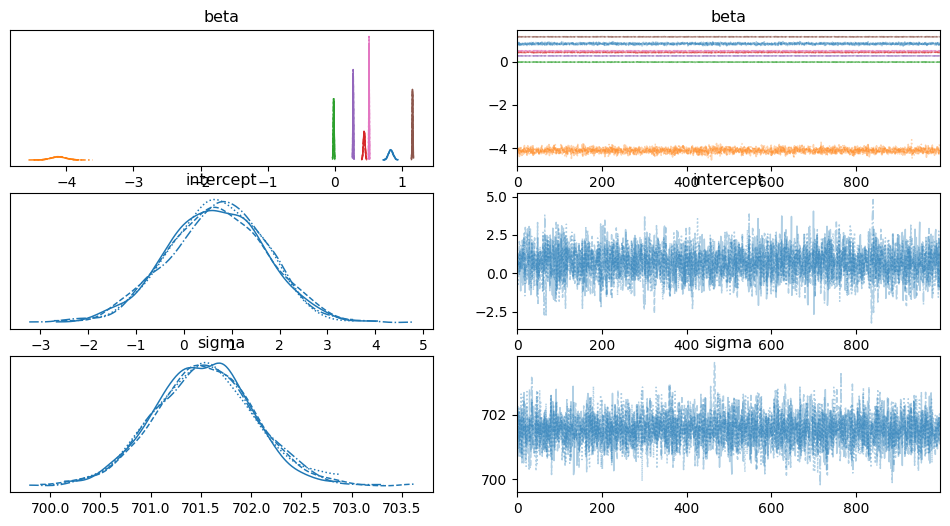

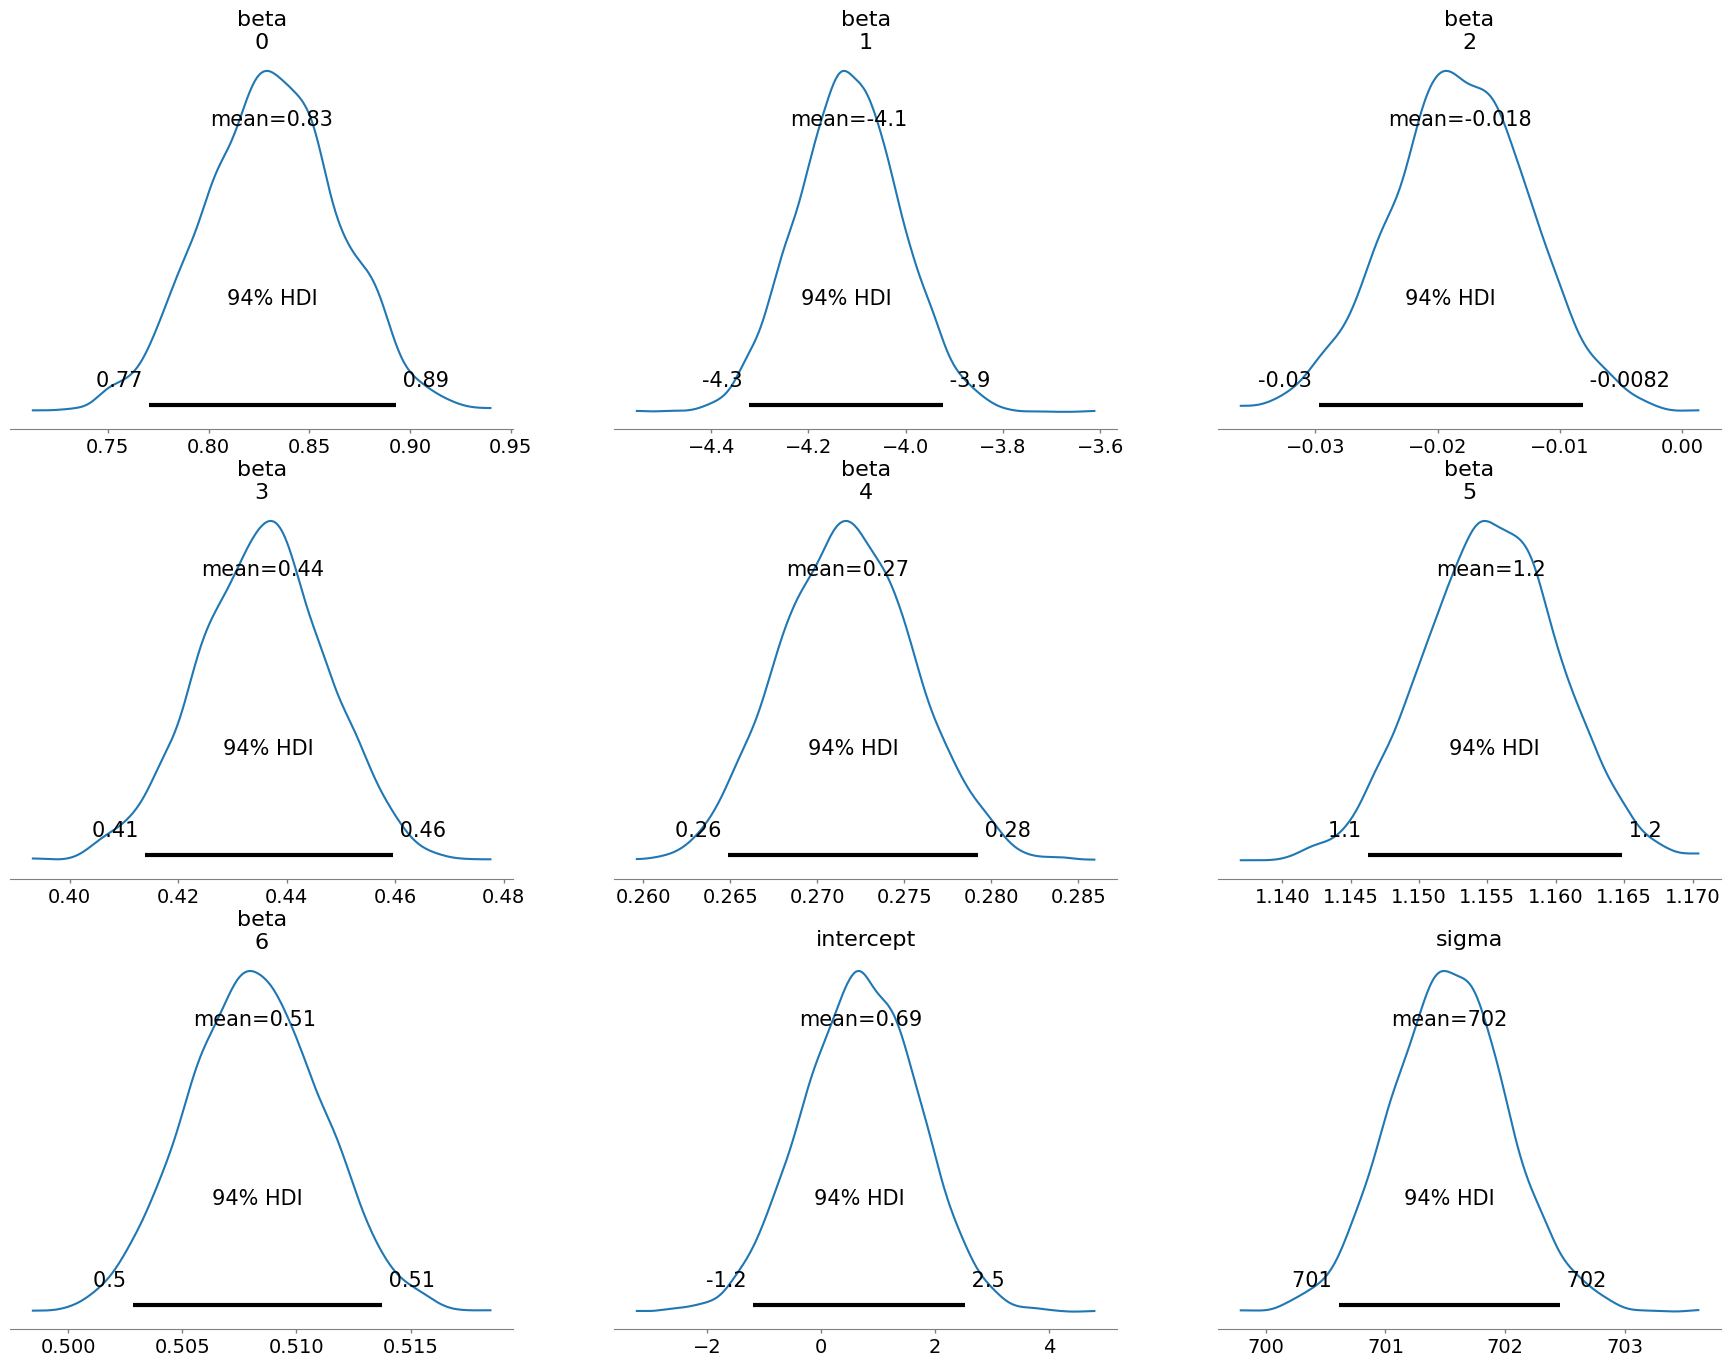

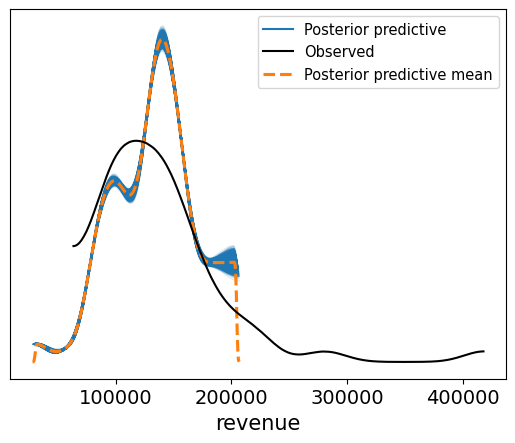

In [10]:
# model performance evaluation using trace plots
with model:
    pm.plot_trace(trace)
    pm.plot_posterior(trace)
    ppc = pm.sample_posterior_predictive(trace, var_names=['revenue'])
    pm.plot_ppc(ppc)

In [11]:
# Interpret results
beta_mean = trace.posterior['beta'].mean(dim=('chain', 'draw'))
intercept_mean = trace.posterior['intercept'].mean(dim=('chain', 'draw'))
print("Estimated Coefficients:", beta_mean.values)
print("Intercept:", intercept_mean.values)

Estimated Coefficients: [ 0.83132059 -4.11626572 -0.01821457  0.4355152   0.27171807  1.15528592
  0.50816272]
Intercept: 0.6924458954783772


In [12]:
# ROI
mean_spends = df[[f'spend_channel_{i}' for i in range(1, 8)]].mean()
roi = (beta_mean * mean_spends) / df['revenue'].mean()
print("ROI per channel:", roi)

ROI per channel: <xarray.DataArray (beta_dim_0: 7)> Size: 56B
array([ 0.0075866 , -0.01036351, -0.00260323,  0.02206493,  0.01707191,
        0.04286037,  0.10313417])
Coordinates:
  * beta_dim_0  (beta_dim_0) int32 28B 0 1 2 3 4 5 6


In [16]:
import pymc as pm
import arviz as az
# mean values for beta, intercept, and sigma
beta_mean = trace.posterior['beta'].mean(dim=('chain', 'draw')).values
intercept_mean = trace.posterior['intercept'].mean(dim=('chain', 'draw')).values.item()
sigma_mean = trace.posterior['sigma'].mean(dim=('chain', 'draw')).values.item()

# standard deviation values for intercept and sigma
intercept_std = trace.posterior['intercept'].std(dim=('chain', 'draw')).values.item()
sigma_std = trace.posterior['sigma'].std(dim=('chain', 'draw')).values.item()

# standard deviations for all beta coefficients
beta_std = trace.posterior['beta'].std(dim=('chain', 'draw')).values

# Get the results
print("Estimated Coefficients (beta):", beta_mean)
print("Posterior Std Dev (beta):", beta_std)
print("Intercept - Posterior Mean:", intercept_mean)
print("Intercept - Posterior Std Dev:", intercept_std)
print("Sigma - Posterior Mean:", sigma_mean)
print("Sigma - Posterior Std Dev:", sigma_std)


Estimated Coefficients (beta): [ 0.83132059 -4.11626572 -0.01821457  0.4355152   0.27171807  1.15528592
  0.50816272]
Posterior Std Dev (beta): [0.03349346 0.10652819 0.0056899  0.0121152  0.00385694 0.00500724
 0.00291762]
Intercept - Posterior Mean: 0.6924458954783772
Intercept - Posterior Std Dev: 1.009119835946438
Sigma - Posterior Mean: 701.5347582899483
Sigma - Posterior Std Dev: 0.4917080182534376
